In [43]:
def gapCheck(indf, cur_huc): 
    """Check for gaps in dataframe with COMID and date columns"""
    gap_hucs = []
    gap_end_date = []
    gap_length = []
    no_comids = []
   
    indf_sorted = indf.sort_values(by = ['COMID', 'date'])
    indf_sorted['timedelta'] = indf_sorted['date'].diff()
    indf_gaps = indf_sorted[indf_sorted.timedelta > '1 day']
    if len(indf_gaps) > 0:
        print(f'Gaps in {cur_huc}')
        for d in indf_gaps.date.unique():
            for l in indf_gaps.loc[(indf_gaps.date == d)].timedelta.unique():
                cur_gap = indf_gaps.loc[(indf_gaps.date == d) & (indf_gaps.timedelta == l)]
                gap_hucs.append(cur_huc)
                gap_end_date.append(d.date())
                gap_length.append(l)
                no_comids.append(round(len(cur_gap.COMID.unique())/len(indf.COMID.unique()), 2))
        return pd.DataFrame({'end_date': gap_end_date, 'length': gap_length, 'fraction_COMIDS': no_comids})
    else: return pd.DataFrame()

In [1]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import xarray as xr
import glob
import os

import py7zr
import zipfile

In [2]:
# the following use ~ mm/21/yy dates for cutting (i.e. spring starts on March 21) - per Aimee

def assign_season(doy):
    """Assigns a season based on the day of year (doy)."""
    if 1 <= doy <= 79:
        return "winter"
    elif 80 <= doy <= 171:
        return "spring"
    elif 172 <= doy <= 263:
        return "summer"
    elif 264 <= doy <= 356:
        return "fall"
    else:
        return "winter"

In [3]:
def assign_water_year(date):
    """Assigns water year (Oct-Sept) based on date."""
    if date.month >= 10:
        return (date.year +1)
    else: return date.year

In [4]:
# (~4 sec/HUC)
def getSeasonalAnomalies(indf, baseline_period: range, anomaly_periods: list, cols: list):
    cur_huc_anoms = []
    cur_comids = list(indf.COMID.unique())
    for j in cur_comids:
        #Assign water year and season
        cur_df = indf[indf.COMID == j][['date']+ cols]
        cur_ens_med = cur_df.groupby('date').median() # sets index to date
        cur_ens_med['doy'] = cur_ens_med.index.dayofyear
        cur_ens_med['season'] = cur_ens_med['doy'].apply(assign_season)
        for col in cols: cur_ens_med[f'n_{col}'] = cur_ens_med[col].notnull().astype(int)

        if 'cov.SWE' in cols:
            #Use water year for swe
            cur_swe = cur_ens_med.copy()
            cur_swe['WY'] = cur_swe.index.to_series().apply(assign_water_year)
    
            # Reclassify end of Sept as summer (pull it into summer of WY[y-1])
            cur_swe.loc[cur_swe.index.month == 9, 'season'] = 'summer'        
            swe_cum = cur_swe[['cov.SWE', 'WY', 'season', 'n_cov.SWE']].groupby(['WY', 'season']).sum()

        
        cur_anomalies = {}
        
        #Determine baseline (median)
        cur_met = cur_ens_med.copy()
        baseline = cur_met[cur_met.index.year.isin(baseline_period)].groupby('season').median()
        for col in cols: 
            baseline[f'n_{col}'] = cur_met[cur_met.index.year.isin(baseline_period)].groupby('season').sum()[f'n_{col}'] # n
            
        if 'cov.SWE' in cols:
            swe_df = swe_cum.loc[pd.IndexSlice[baseline_period], :, :]                
            baseline['cov.SWE'] = swe_df.groupby(level=1).median()['cov.SWE']
            baseline['n_cov.SWE'] = swe_df.groupby(level=1).sum()['n_cov.SWE'] # n
        
        
        baseline_trim = pd.concat([baseline[[col, f'n_{col}']] for col in cols], axis = 1)
        
        cur_anomalies[f'{baseline_period[0]}s'] = baseline_trim

        #Calculate anomalies
        for per in anomaly_periods:                
            cur_anoms = cur_ens_med[cur_ens_med.index.year.isin(per)].groupby('season').median().subtract(baseline)
            for col in cols: 
                cur_anoms[f'n_{col}'] = cur_ens_med[cur_ens_med.index.year.isin(per)].groupby('season').sum()[f'n_{col}'] # n

            if 'cov.SWE' in cols:
                swe = swe_cum.loc[pd.IndexSlice[per], :, :]                
                cur_anoms['cov.SWE'] = swe.groupby(level=1).median()['cov.SWE'].subtract(baseline['cov.SWE'])
                cur_anoms['n_cov.SWE'] = swe.groupby(level=1).sum()['n_cov.SWE'] # n
            
            cur_anoms_trim = pd.concat([cur_anoms[[col, f'n_{col}']] for col in cols], axis = 1)
            
            cur_anomalies[f'{per[0]}s'] = cur_anoms_trim
        
        cur_seas_anomalies = pd.concat(cur_anomalies, axis = 1)
        cur_huc_anoms.append(cur_seas_anomalies)
    return pd.concat(cur_huc_anoms, keys = cur_comids)
 

In [6]:
def recalculate_anomalies(predictions_file):
    cur_huc = predictions_file[-14:-4] 
    #print('\n', f'{cur_huc}')

    stdf = pd.read_csv(predictions_file, parse_dates = ['tim.date'], engine = 'python', on_bad_lines = 'warn')
    stdf.drop('lookup', axis = 1, inplace = True)
    
    # Compare to old predictions:
    old_prd_file = os.path.join(temp_dir_retro, 'Archive20250311', 'temp_predictions_archive', f'st_pred_{cur_huc}.csv')
    olddf = pd.read_csv(old_prd_file, parse_dates = ['tim.date'], engine = 'python', on_bad_lines = 'warn')
    
    if (len(stdf)==len(olddf)) & (stdf.subtract(olddf.drop('lookup', axis = 1))['prd.stream_temp'].dropna().sum() != 0.00):
        return(int(cur_huc)) 
        # print('\tCalculating', cur_huc)
        # stdf.rename({'tim.date': 'date'}, axis = 1, inplace = True)
        # try:
        #     print('\tRecalculating anomalies...')
        #     huc_anoms_retro = getSeasonalAnomalies(stdf, baseline_period = periods['2010s'], 
        #                                 anomaly_periods = [periods[key] for key in ('1990s', '2000s')], cols = ['prd.stream_temp'])
            
        #     huc_anoms_retro.reset_index(names = ['COMID', 'season']).to_csv(
        #         os.path.join(temp_dir_retro, 'seasonal_anomalies', f'{cur_huc}_anoms.zip'), index = False, compression = 'zip')
        #     print('\tDone')
        # # except: pass
        # except: print('Fail')
    else: return(cur_huc)

In [6]:
def calculate_anomalies(predictions_file):
    cur_huc = predictions_file[-14:-4] 
    print('\n', f'{cur_huc}')

    stdf = pd.read_csv(predictions_file, parse_dates = ['tim.date'], engine = 'python', on_bad_lines = 'warn')
    stdf.drop('lookup', axis = 1, inplace = True)
    
    print('\tCalculating', cur_huc)
    stdf.rename({'tim.date': 'date'}, axis = 1, inplace = True)
    try:
        print('\tCalculating anomalies...')
        huc_anoms_retro = getSeasonalAnomalies(stdf, baseline_period = periods['2010s'], 
                                    anomaly_periods = [periods[key] for key in ('1990s', '2000s')], cols = ['prd.stream_temp'])
        
        huc_anoms_retro.reset_index(names = ['COMID', 'season']).to_csv(
            os.path.join(temp_dir_retro, 'seasonal_anomalies', f'{cur_huc}_anoms.zip'), index = False, compression = 'zip')
        print('\tDone')
    # except: pass
    except: print('Fail')
    else: return(cur_huc)

In [5]:
file = os.path.join(temp_dir_retro, 'DATA', 'predictions_temperature', 'st_pred_1701010109.csv')
file

NameError: name 'temp_dir_retro' is not defined

In [6]:
calculate_anomalies(file)

NameError: name 'calculate_anomalies' is not defined

### Import shared files

In [7]:
covariate_metadata = pd.read_csv('../DATA/Stream_Temp/covariate_metadata.csv', nrows = 100)
covariate_metadata.tail(5)

,COVARIATE,UNITS,SYMBOL,DESCRIPTION,DATA SOURCE (Retrospective),DATA SOURCE (GCM Scenarios)
95,lookup,unitless,not used,"concatination of reach identifier, year, and d...",NaN,NaN
96,tim.date,date,not used,date,NaN,NaN
97,tim.year,year,not used,year,NaN,NaN
98,cov.canopy_rca,percent,not used,proportional canopy cover in the reach contrib...,need to check,NaN
99,cov.canopy_ws,percent,not used,proportional canopy cover in the upstream wate...,need to check,NaN


In [8]:
gcm_metadata = pd.read_csv('../DATA/Stream_Temp/gcm_metadata.csv', nrows = 10)
gcm_metadata

,Global Climate Model short name,GCM long name,Country,Agency,Coupled Model Intercomparison Project version,Emissions scenario,Downscaling method,Hydrology model,Network routing
0,CanESM2,Canadian Earth System Model version 2,Canada,Canadian Centre for Climate Modeling and Analysis,5,RCP 8.5,Multivariate Adaptive Constructed Analogs (Aba...,"Variable Infiltration Capacity, using paramete...",mizuRoute (Mizukami 2019)
1,CCSM4,Community Climate System Model version 4,USA,"National Center of Atmospheric Research, USA",5,RCP 8.5,Multivariate Adaptive Constructed Analogs (Aba...,"Variable Infiltration Capacity, using paramete...",mizuRoute (Mizukami 2019)
2,CNRM-CM5,National Center for Meteorological Research Mo...,France,"National Centre of Meteorological Research, Fr...",5,RCP 8.5,Multivariate Adaptive Constructed Analogs (Aba...,"Variable Infiltration Capacity, using paramete...",mizuRoute (Mizukami 2019)
3,CSIRO-Mk3-6-0,Commonwealth Scientific and Industrial Researc...,Australia,Commonwealth Scientific and Industrial Researc...,5,RCP 8.5,Multivariate Adaptive Constructed Analogs (Aba...,"Variable Infiltration Capacity, using paramete...",mizuRoute (Mizukami 2019)
4,GDFL-ESM2M,Global Fluid Dynamics Lab's Earth Systems Mode...,USA,"NOAA Geophysical Fluid Dynamics Laboratory, USA",5,RCP 8.5,Multivariate Adaptive Constructed Analogs (Aba...,"Variable Infiltration Capacity, using paramete...",mizuRoute (Mizukami 2019)
5,HadGEM-CC365,"Hadley Centre Global Environmental Model, Clim...",UK,"Met Office Hadley Center, UK",5,RCP 8.5,Multivariate Adaptive Constructed Analogs (Aba...,"Variable Infiltration Capacity, using paramete...",mizuRoute (Mizukami 2019)
6,HadGEM2-ES,"Hadley Centre Global Environmental Model, Eart...",UK,"Met Office Hadley Center, UK",5,RCP 8.5,Multivariate Adaptive Constructed Analogs (Aba...,"Variable Infiltration Capacity, using paramete...",mizuRoute (Mizukami 2019)
7,inmcm4,"Institute of Numerical Mathematics, Coupled Mo...",Russia,"Institute of Numerical Mathematics, Russia",5,RCP 8.5,Multivariate Adaptive Constructed Analogs (Aba...,"Variable Infiltration Capacity, using paramete...",mizuRoute (Mizukami 2019)
8,IPSL-CM5A-MR,Institut Pierre Simon Laplace Climate Model,France,"Institut Pierre Simon Laplace, France",5,RCP 8.5,Multivariate Adaptive Constructed Analogs (Aba...,"Variable Infiltration Capacity, using paramete...",mizuRoute (Mizukami 2019)
9,MIROC5,Model for Interdisciplinary Research on Climat...,Japan,Atmosphere and Ocean Research Institute (The U...,5,RCP 8.5,Multivariate Adaptive Constructed Analogs (Aba...,"Variable Infiltration Capacity, using paramete...",mizuRoute (Mizukami 2019)


In [21]:
gcms = list(gcm_metadata.iloc[:, 0].values)

shortname_dict = {i+1:gcms[i] for i in list(range(10))}
shortname_dict

{1: 'CanESM2',
 2: 'CCSM4',
 3: 'CNRM-CM5',
 4: 'CSIRO-Mk3-6-0',
 5: 'GDFL-ESM2M',
 6: 'HadGEM-CC365',
 7: 'HadGEM2-ES',
 8: 'inmcm4',
 9: 'IPSL-CM5A-MR',
 10: 'MIROC5'}

In [2]:
temp_dir = '/Volumes/Elements/URycki/Repos/temp-data/'
temp_dir

'/Volumes/Elements/URycki/Repos/temp-data/'

In [8]:
periods = {'2000s': list(range(2000, 2010)),
           '2010s': list(range(2010, 2020)),
           '2020s': list(range(2020, 2030)), 
           '1990s': list(range(1990, 2000)), 
           '2050s': list(range(2050, 2060)), 
           '2080s': list(range(2080, 2090))}

In [9]:
temp_dir_gcms = os.path.join(temp_dir, 'preds_GCM/')
temp_files_gcms = glob.glob(temp_dir_gcms + '*.nc')
print(len(temp_files_gcms))
temp_files_gcms.sort()

0


In [3]:
temp_dir_retro = os.path.join(temp_dir, 'DATA', 'preds_retro')
temp_files_retro = glob.glob(os.path.join(temp_dir_retro, 'predictions_temperature', '*.csv'))
print(len(temp_files_retro))
print(temp_files_retro[:3])
temp_files_retro.sort()

1539
['/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro/predictions_temperature/st_pred_1712000908.csv', '/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro/predictions_temperature/st_pred_1712000907.csv', '/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro/predictions_temperature/st_pred_1712000906.csv']


In [11]:
old_prd_files = glob.glob(os.path.join(temp_dir_retro, 'Archive20250311', 'temp_predictions_archive', '*.csv'))
len(old_prd_files)

1541

In [12]:
retro_hucs = [int(f[-14:-4]) for f in temp_files_retro]
retro_hucs.sort()
retro_hucs[0]
curh6 = int(str(retro_hucs[180])[:6])
curh6


170103

In [44]:
retro_hucs
curh10s = [h10 for h10 in temp_files_retro if h10[-14:-6] == str(curh6)+'08']
curh10s

['/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro/predictions_temperature/st_pred_1701030801.csv',
 '/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro/predictions_temperature/st_pred_1701030802.csv',
 '/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro/predictions_temperature/st_pred_1701030803.csv']

In [72]:
df1 = pd.read_csv(curh10s[0])
df1 = df1.rename(columns = {'tim.date': 'date'})
df1['date'] = pd.to_datetime(df1.date)
df1.dtypes

lookup                        object
COMID                          int64
date                  datetime64[ns]
cov.antec_air_temp           float64
cov.std_mean_flow            float64
prd.stream_temp              float64
dtype: object

In [73]:
gap1 = gapCheck(df1, curh10s[1][-14:-4])
gap1

""


array([[<Axes: title={'center': 'prd.stream_temp'}>]], dtype=object)

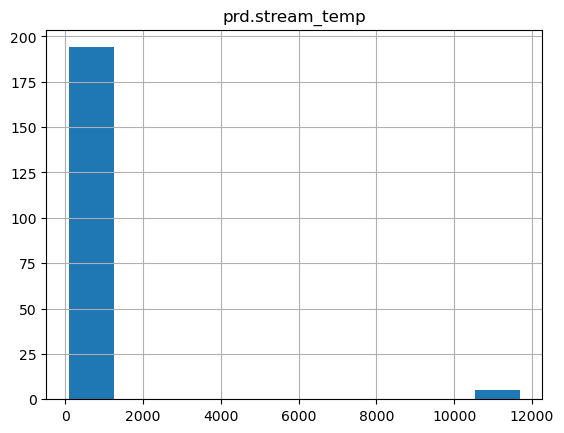

In [74]:
df1[['COMID', 'prd.stream_temp']].loc[df1['prd.stream_temp'].isnull()].fillna(1).groupby(['COMID']).sum().hist()

In [18]:
hucs = [f[-13:-3] for f in temp_files_gcms]
#hucs

## Compute temperature anomalies

### Future (GCM) projections

In [35]:
%%time

for cur_huc in hucs[:2]:

    preds = xr.open_dataset(f'/Volumes/Elements/URycki/temp_data/preds_GCM/{cur_huc}.nc', decode_times=True)
    predsdf = preds.to_dataframe(dim_order = ['COMID', 'GCM', 'date'])
    preds_flat = predsdf.reset_index()

    huc_anoms = getSeasonalAnomalies(preds_flat, baseline_period = periods['2010s'], 
                            anomaly_periods = [periods[key] for key in ('1990s', '2050s', '2080s')], cols = ['prd.stream_temp'])
    
    #huc_anoms.reset_index(names = ['COMID', 'season']).to_csv(
        #os.path.join(temp_dir_gcms, 'seasonal_anomolies', f'{cur_huc}_anoms.csv'), index = False, compression = 'zip')

1701010107
1701010108
CPU times: user 5.72 s, sys: 569 ms, total: 6.29 s
Wall time: 10.8 s


In [37]:
# Check
pd.read_csv(os.path.join(temp_dir_gcms, 'seasonal_anomolies', f'{cur_huc}_anoms.csv'), header=[0,1])

COMID             season           2010s                    \
    Unnamed: 0_level_1 Unnamed: 1_level_1 prd.stream_temp n_prd.stream_temp   
0             22878623               fall        3.921150               930   
1             22878623             spring        8.469155               920   
2             22878623             summer       15.968426               920   
3             22878623             winter        0.794843               882   
4             22878625               fall        3.965583               930   
..                 ...                ...             ...               ...   
123           22879895             winter        0.323003               882   
124           22879989               fall        2.040540               930   
125           22879989             spring        3.544079               920   
126           22879989             summer        8.605773               920   
127           22879989             winter        0.726483               882   

              1990s                             2050s                    \
    prd.stream_temp n_prd.stream_temp prd.stream_temp n_prd.stream_temp   
0         -0.299178               930        1.096812               930   
1         -0.411885               920        1.633280               920   
2         -0.946710               920        1.242376               920   
3         -0.155174               882        0.526287               882   
4         -0.296498               930        1.080081               930   
..              ...               ...             ...               ...   
123        0.103842               882        0.419040               882   
124       -0.095128               930        0.127186               930   
125       -0.016492               920        0.421183               920   
126       -0.496326               920        0.659330               920   
127       -0.097199               882        0.197353               882   

              2080s                    
    prd.stream_temp n_prd.stream_temp  
0          2.240112               930  
1          2.942516               920  
2          2.557516               920  
3          1.571385               883  
4          2.268231               930  
..              ...               ...  
123        1.216069               883  
124        0.459159               930  
125        0.953634               920  
126        1.039228               920  
127        0.324427               883  

[128 rows x 10 columns]

### Retrospective 

In [48]:
%%time
# Retrospective (by 10-digit HUC)

temp_files_retro.sort()
print(len(temp_files_retro), ' huc10s')

1539  huc10s
CPU times: user 565 μs, sys: 115 μs, total: 680 μs
Wall time: 646 μs


In [ ]:
%%time 
# ~1 min/huc

nochange = []
for h in temp_files_retro:
    nochange.append(recalculate_anomalies(h))

In [49]:
temp_files_retro[0][-14:-8]

'170101'

In [50]:
curh10s = [h10 for h10 in temp_files_retro if h10[-14:-8] == str(curh6)]
curh10s

['/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro/predictions_temperature/st_pred_1701030101.csv',
 '/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro/predictions_temperature/st_pred_1701030102.csv',
 '/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro/predictions_temperature/st_pred_1701030103.csv',
 '/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro/predictions_temperature/st_pred_1701030104.csv',
 '/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro/predictions_temperature/st_pred_1701030105.csv',
 '/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro/predictions_temperature/st_pred_1701030106.csv',
 '/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro/predictions_temperature/st_pred_1701030107.csv',
 '/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro/predictions_temperature/st_pred_1701030201.csv',
 '/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro/predictions_temperature/st_pred_1701030202.csv',
 '/Volumes/Elements

In [51]:
temp_files_retro[0]

'/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro/predictions_temperature/st_pred_1701010106.csv'

In [103]:
temp_files_retro[0][-14:-4]

'1701010106'

In [ ]:
%%time 

nochange = [] #string = no change; int = used revised calculations
recalculate = []
for h in temp_files_retro[241:]:
    h10 = str(h[-14:-4])
    #nochange.append(recalculate_anomalies(h))
    res = recalculate_anomalies(h)
    
    dest = os.path.join(temp_dir_retro, 'seasonal_anomalies', f'{h10}_anoms.zip')

    if type(res) == int:
        print('Changed', res, '...')
        if not os.path.exists(dest): 
            print(f'{h10} revised file does not exist')
            recalculate.append(h10)
        print('Done')
    
    if type(res) == str: 
        print('Moving', res)
        source = os.path.join(temp_dir_retro, 'seasonal_anomalies', 'Archive20250311', f'{h10}_anoms.zip')
        os.rename(source, dest)
        print('Done')

Moving 1702000718
Done
Changed 1702000719 ...
1702000719 revised file does not exist
Done
Moving 1702000720
Done
Changed 1702000801 ...
1702000801 revised file does not exist
Done
Changed 1702000802 ...
1702000802 revised file does not exist
Done
Moving 1702000803
Done
Changed 1702000804 ...
1702000804 revised file does not exist
Done
Changed 1702000805 ...
1702000805 revised file does not exist
Done
Changed 1702000806 ...
1702000806 revised file does not exist
Done
Changed 1702000807 ...
1702000807 revised file does not exist
Done
Changed 1702000901 ...
1702000901 revised file does not exist
Done
Moving 1702000902
Done
Moving 1702000903
Done
Changed 1702001001 ...
1702001001 revised file does not exist
Done
Changed 1702001002 ...
1702001002 revised file does not exist
Done
Moving 1702001003
Done
Moving 1702001004
Done
Moving 1702001005
Done
Changed 1702001101 ...
1702001101 revised file does not exist
Done
Changed 1702001102 ...
1702001102 revised file does not exist
Done
Changed 1702

In [117]:
#temp_files_retro.index(h) [240]

240

In [114]:
nochange

[]

In [115]:
recalculate

[]

In [99]:
for h in nochange:
    dest = os.path.join(temp_dir_retro, 'seasonal_anomalies', f'{h}_anoms.zip')

    if type(h) == int:
        if not os.path.exists(dest): print(f'{h} revised file does not exist')

    if type(h) == str: 
        print(h)
        source = os.path.join(temp_dir_retro, 'seasonal_anomalies', 'Archive20250311', f'{h}_anoms.zip')
        os.rename(source, dest)
        
     

In [ ]:
   
        # On Windows, a file with that name must not exist or an exception will be raised, but os.replace() will silently replace a file even in that occurrence.
        os.replace(f"Volumes/Elements/URycki/temp_data/preds_retro/seasonal_anomalies/Archive20250311/{h}_anoms.zip", 
                  f"/Volumes/Elements/URycki/temp_data/preds_retro/seasonal_anomalies/{h}_anoms.zip")
        
        if os.path.exists(f"/Volumes/Elements/URycki/temp_data/preds_retro/seasonal_anomalies/Archive20250311/{h}_anoms.zip"): print('yep')

1701010106
1701010107
1701010108
1701010109
1701010110
1701010111
1701010112
1701010113
1701010114
1701010115
1701010116
1701010117
1701010201
1701010202
1701010203
1701010204
1701010301
1701010302
1701010303
1701010304
1701010305
1701010401
1701010402
1701010403
1701010404
1701010405
1701010406
1701010407
1701010502
1701010504
1701010505
1701010607


In [73]:
h = str(nochange[0])
h

'1701010106'

In [75]:
testold = pd.read_csv(f'/Volumes/Elements/URycki/temp_data/preds_retro/seasonal_anomalies/Archive20250311/{h}_anoms.zip', compression = 'zip')
testold

,COMID,season,2010s,2010s.1,1990s,1990s.1,2000s,2000s.1
0,NaN,NaN,prd.stream_temp,n_prd.stream_temp,prd.stream_temp,n_prd.stream_temp,prd.stream_temp,n_prd.stream_temp
1,22878865.0,fall,NaN,0,NaN,0,NaN,0
2,22878865.0,spring,NaN,0,NaN,0,NaN,0
3,22878865.0,summer,NaN,0,NaN,0,NaN,0
4,22878865.0,winter,NaN,0,NaN,0,NaN,0


In [65]:
testnew = pd.read_csv(f'/Volumes/Elements/URycki/temp_data/preds_retro/seasonal_anomalies/{h}_anoms.zip', compression = 'zip')
testold

,COMID,season,2010s,2010s.1,1990s,1990s.1,2000s,2000s.1
0,NaN,NaN,prd.stream_temp,n_prd.stream_temp,prd.stream_temp,n_prd.stream_temp,prd.stream_temp,n_prd.stream_temp
1,22879233.0,fall,1.63355903591401,930,-0.11315927867362507,930,0.07177159077723516,930
2,22879233.0,spring,3.7457932005023,920,-0.23787177746863986,920,-0.04712121476753506,920
3,22879233.0,summer,9.6847968399431,920,-1.3691814773420568,920,-0.13002059756750128,920
4,22879233.0,winter,1.05217565164685,882,-0.06929475258499984,865,-0.05028837376916995,883
...,...,...,...,...,...,...,...,...
108,22882371.0,winter,0.378330027497882,882,0.24108179932041396,871,0.23555323868912292,883
109,22882377.0,fall,1.19642751788961,930,0.09127042089822512,930,0.11504264144491994,930
110,22882377.0,spring,1.398372518594075,920,0.045740724404815136,920,0.2510294241777151,920
111,22882377.0,summer,4.720402239683345,920,-0.8889086792870451,920,0.04808472610770487,920


In [51]:
# if not os.path.exists(source_path):
if os.path.exists(os.path.join(temp_dir_retro, 'seasonal_anomalies', f'{h}_anoms.zip')): print('yep.')

In [48]:
h = nochange[0]
h

'1701010106'

In [47]:
f'{h}_anoms.zip'

'1701010607_anoms.zip'

In [145]:
#conda install multiprocess

In [ ]:
import multiprocess as mp

%%time
nochange_pool = []
with mp.Pool(5) as pool:
    nochange_pool = pool.map(recalculate_anomalies, temp_files_retro[:10])

In [146]:
nochange_pool

[None, None, None, None, None, None, None, None, None, None]

In [152]:
%%time
nochange_pool = []
with mp.Pool(5) as pool:
    nochange_pool = pool.map(recalculate_anomalies, temp_files_retro)

/var/folders/95/99dy_ns968195cnlvp5xhwqm0000gp/T/ipykernel_13168/3393587739.py:5: ParserWarning: Skipping line 2142853: field larger than field limit (131072)

  stdf = pd.read_csv(predictions_file, parse_dates = ['tim.date'], engine = 'python', on_bad_lines = 'warn')
/var/folders/95/99dy_ns968195cnlvp5xhwqm0000gp/T/ipykernel_13168/3393587739.py:5: ParserWarning: Skipping line 2486435: field larger than field limit (131072)

  stdf = pd.read_csv(predictions_file, parse_dates = ['tim.date'], engine = 'python', on_bad_lines = 'warn')
/var/folders/95/99dy_ns968195cnlvp5xhwqm0000gp/T/ipykernel_13168/3393587739.py:5: ParserWarning: Skipping line 997910: field larger than field limit (131072)

  stdf = pd.read_csv(predictions_file, parse_dates = ['tim.date'], engine = 'python', on_bad_lines = 'warn')


TypeError: cannot subtract DatetimeArray from ndarray

In [153]:
nochange_pool


[]

In [ ]:
temp_files-

In [106]:
huc_anoms_retro

2010s                             1990s  \
                 prd.stream_temp n_prd.stream_temp prd.stream_temp   
          season                                                     
24125037  fall          8.782076               930       -1.468011   
          spring       11.503340               920       -0.337688   
          summer       20.114952               920       -1.149293   
          winter        4.126490               882       -0.062737   
24125039  fall          8.792996               930       -1.525282   
...                          ...               ...             ...   
947030184 winter        4.827004               882        0.001746   
947030185 fall          7.957505               930       -0.276228   
          spring       12.440891               920       -0.297376   
          summer       15.336318               920       -0.350425   
          winter        5.334049               882        0.033426   

                                             2000s                    
                 n_prd.stream_temp prd.stream_temp n_prd.stream_temp  
          season                                                      
24125037  fall                 930       -0.687713               930  
          spring               920       -0.491780               920  
          summer               920       -0.271537               920  
          winter               868       -0.069949               883  
24125039  fall                 930       -0.717155               930  
...                            ...             ...               ...  
947030184 winter               880       -0.119326               883  
947030185 fall                 930       -0.271460               930  
          spring               920       -0.234241               920  
          summer               920       -0.095080               920  
          winter               880       -0.035999               883  

[1192 rows x 6 columns]

In [ ]:
test_stdf[test_stdf.notnull(subset + )]

In [107]:
stdf

,COMID,date,cov.antec_air_temp,cov.std_mean_flow,prd.stream_temp
0,24125037,1990-01-01,NaN,-0.056351,NaN
1,24125039,1990-01-01,NaN,-0.056439,NaN
2,24125041,1990-01-01,NaN,-0.050853,NaN
3,24125043,1990-01-01,NaN,-0.050851,NaN
4,24125047,1990-01-01,NaN,-0.042799,NaN
...,...,...,...,...,...
3483019,947030062,2021-12-31,-7.682600,-5.000000,NaN
3483020,947030168,2021-12-31,-3.612978,-0.409888,NaN
3483021,947030169,2021-12-31,-3.612978,-0.415102,NaN
3483022,947030184,2021-12-31,-8.038700,-2.783653,NaN


In [30]:
daily_temp_dict[h6].max()

COMID                        947010193
date               2021-12-31 00:00:00
prd.stream_temp              28.360138
dtype: object

In [34]:
#daily_temp_dict[h6].to_csv(os.path.join(temp_dir_retro, tmp_path, f'{h6}_daily_temp.zip'), index = False, compression = 'zip')

In [18]:
import matplotlib.pyplot as plt

170101


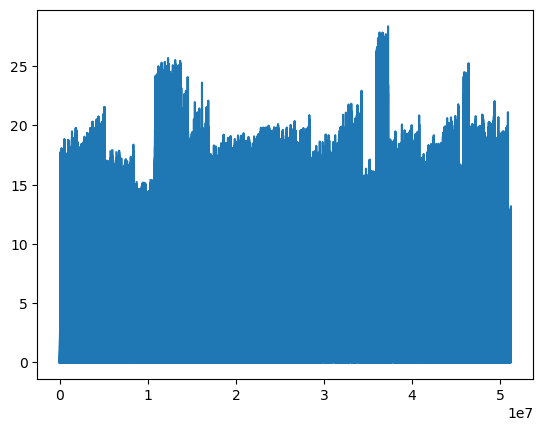

170102


OverflowError: Exceeded cell block limit in Agg.  Please set the value of rcParams['agg.path.chunksize'], (currently 0) to be greater than 100 or increase the path simplification threshold(rcParams['path.simplify_threshold'] = 0.111111111111 by default and path.simplify_threshold = 0.111111111111 on the input).

<Figure size 640x480 with 1 Axes>

170103


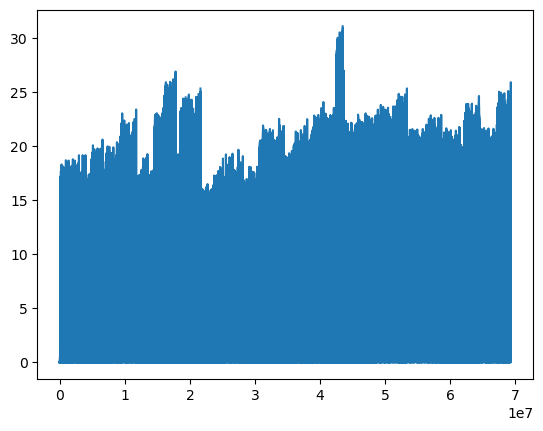

170200


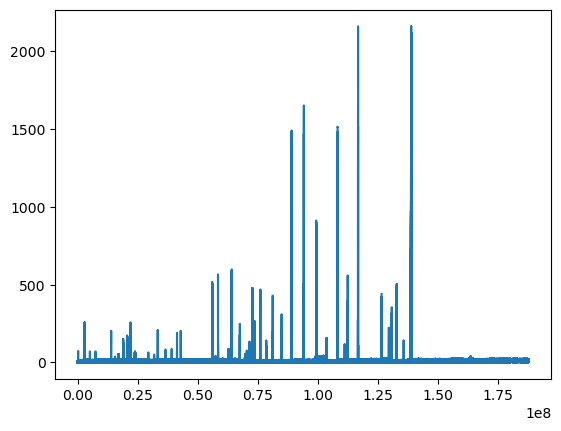

170300


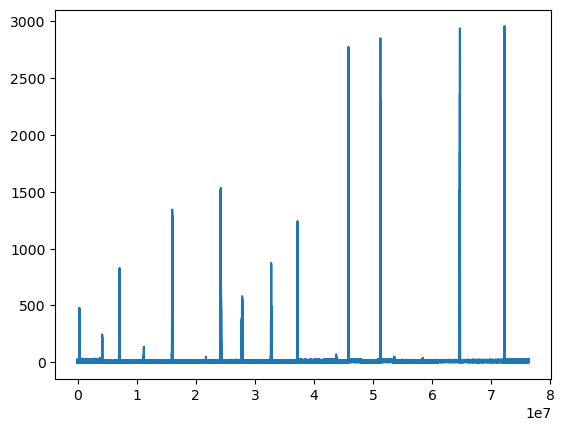

170401


OverflowError: Exceeded cell block limit in Agg.  Please set the value of rcParams['agg.path.chunksize'], (currently 0) to be greater than 100 or increase the path simplification threshold(rcParams['path.simplify_threshold'] = 0.111111111111 by default and path.simplify_threshold = 0.111111111111 on the input).

<Figure size 640x480 with 1 Axes>

170402


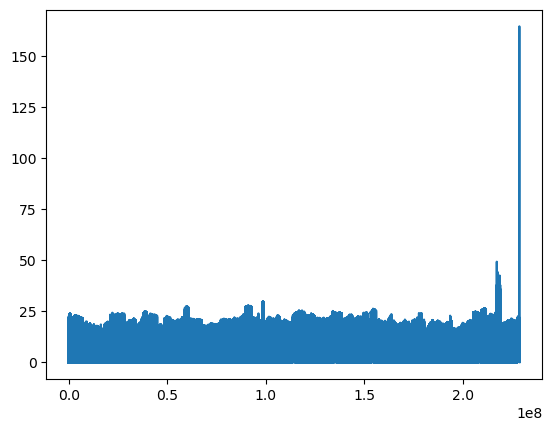

KeyboardInterrupt: 

In [20]:
%%time
for h6 in huc6s:
    df = pd.read_csv(os.path.join(temp_dir_retro, 'temp_files', f'{h6}', f'{h6}_daily_temp.zip'), compression = 'zip')
    print(h6)
    plt.plot(df['prd.stream_temp'])
    plt.show()

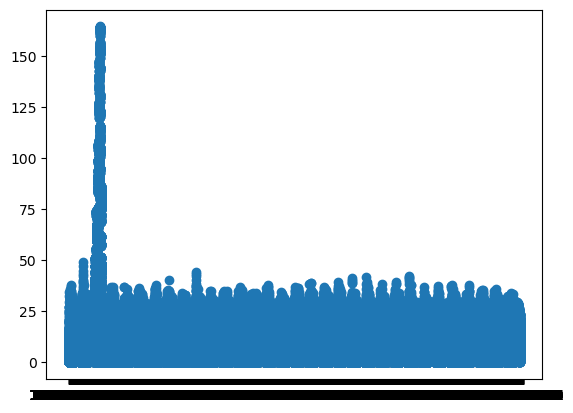

In [22]:
plt.scatter(df['date'], df['prd.stream_temp'])

<Axes: >

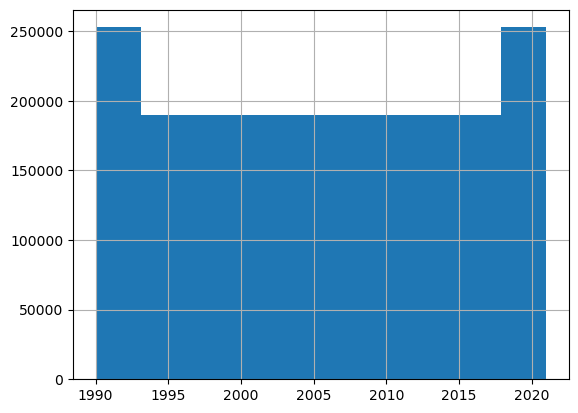

In [42]:
stdf.date.dt.year.hist()

In [40]:
pd.read_csv(os.path.join(temp_dir_retro, 'seasonal_anomalies', f'{cur_huc}_anoms.zip'), header = [0,1],compression = 'zip')

COMID             season           2010s                    \
    Unnamed: 0_level_1 Unnamed: 1_level_1 prd.stream_temp n_prd.stream_temp   
0             22878621               fall        4.236064               930   
1             22878621             spring        8.546325               920   
2             22878621             summer       16.359425               920   
3             22878621             winter        0.765459               882   
4             22878623               fall        4.181419               930   
..                 ...                ...             ...               ...   
543           22880091             winter        1.010729               882   
544           22882601               fall        4.161204               930   
545           22882601             spring        8.885758               920   
546           22882601             summer       13.430251               920   
547           22882601             winter        1.116855               882   

              1990s                             2000s                    
    prd.stream_temp n_prd.stream_temp prd.stream_temp n_prd.stream_temp  
0         -0.751205               930       -0.257328               930  
1         -0.431478               920        0.074813               920  
2         -1.213507               920       -0.092045               920  
3         -0.090745               880       -0.218707               883  
4         -0.786375               930       -0.238767               930  
..              ...               ...             ...               ...  
543        0.175812               880        0.033291               883  
544       -0.882348               930       -0.273883               930  
545       -0.848444               920       -0.233790               920  
546       -1.034649               920       -0.063570               920  
547       -0.060438               875       -0.131826               883  

[548 rows x 8 columns]

In [54]:
cov_csvs

NameError: name 'cov_csvs' is not defined

In [ ]:
# Caution: This cell takes ~3 hours to run
# Cov files
retro_cov_comids = {}
for h in cov_csvs:
    cur_huc = h[-19:-9]
    print('\t', f'{cur_huc}')

    stdf = pd.read_csv(h, usecols = ['COMID'])
    retro_cov_comids[cur_huc] = stdf.COMID.unique().tolist()

In [306]:
frames = []
for k in retro_cov_comids.keys():
    curdf = pd.DataFrame(retro_cov_comids[k], columns = ['COMID']).astype({'COMID': int})
    curdf['huc10'] = k
    frames.append(curdf)
comids = pd.concat(frames).set_index('COMID')
comids.to_csv(os.path.join(temp_dir_retro, 'comids_by_huc_cov_retro.csv'))

In [308]:
comids

,huc10
COMID,
22878861,1701010106
22878865,1701010106
22879677,1701010106
22879685,1701010106
22878641,1701010107
...,...
24073327,1712000908
24073341,1712000908
24073365,1712000908


In [57]:
temp_dir_retro

'/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro'

In [58]:
cov_csvs = glob.glob(os.path.join(temp_dir_retro, 'predictions_covariates', 'cov_csvs', '*'))


['/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro/predictions_covariates/cov_csvs/1701010115_covs.zip',
 '/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro/predictions_covariates/cov_csvs/1701010204_covs.zip',
 '/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro/predictions_covariates/cov_csvs/1701010106_covs.zip',
 '/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro/predictions_covariates/cov_csvs/1701010107_covs.zip',
 '/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro/predictions_covariates/cov_csvs/1701010108_covs.zip',
 '/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro/predictions_covariates/cov_csvs/1701010109_covs.zip',
 '/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro/predictions_covariates/cov_csvs/1701010110_covs.zip',
 '/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro/predictions_covariates/cov_csvs/1701010111_covs.zip',
 '/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro/predictions_covariates/cov_c

In [83]:
cov_csvs[175][-19:-13]

'170103'

In [85]:
cur_cov_csvs = [f for f in cov_csvs if f[-19:-13] == str(curh6) ]

In [86]:
cur_cov_csvs

['/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro/predictions_covariates/cov_csvs/1701030101_covs.zip',
 '/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro/predictions_covariates/cov_csvs/1701030102_covs.zip',
 '/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro/predictions_covariates/cov_csvs/1701030103_covs.zip',
 '/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro/predictions_covariates/cov_csvs/1701030104_covs.zip',
 '/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro/predictions_covariates/cov_csvs/1701030105_covs.zip',
 '/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro/predictions_covariates/cov_csvs/1701030106_covs.zip',
 '/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro/predictions_covariates/cov_csvs/1701030107_covs.zip',
 '/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro/predictions_covariates/cov_csvs/1701030201_covs.zip',
 '/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro/predictions_covariates/cov_c

In [75]:
curh6

170103

In [257]:
test = pd.read_csv(cov_csvs[0], compression = 'zip')

In [261]:
cov_comids = test.COMID.unique().tolist()

In [262]:
cov_comids.sort()

In [264]:
len(cov_comids)

186

In [265]:
test

,COMID,date,lookup,cov.air_temp,cov.air_temp_ws,cov.air_temp_3d,cov.air_temp_6d,cov.air_temp_9d,cov.air_temp_12d,cov.air_temp_15d,...,cov.SWE_ws,cov.NWM_flow,cov.NWM_flow_log,cov.daylength,cov.daylength_hours,cov.SWE_mean_year,cov.SWE_1Apr,cov.SWE_last_doy,cov.antec_air_temp,cov.std_mean_flow
0,22877879,1990-01-01,22877879_1990_1,-0.5130,-1.870418,NaN,NaN,NaN,NaN,NaN,...,143.275688,0.08000,-2.525729,29376.0,8.160,221.080944,605.804877,256.0,NaN,-0.954721
1,22877879,1990-01-02,22877879_1990_2,-0.1100,-2.649545,NaN,NaN,NaN,NaN,NaN,...,211.487660,0.07000,-2.659260,29376.0,8.160,221.080944,605.804877,256.0,NaN,-1.088252
2,22877879,1990-01-03,22877879_1990_3,-3.7580,-6.622552,-1.460333,NaN,NaN,NaN,NaN,...,201.586319,0.07000,-2.659260,29721.6,8.256,221.080944,605.804877,256.0,NaN,-1.088252
3,22877879,1990-01-04,22877879_1990_4,-3.7630,-6.311902,-2.543667,NaN,NaN,NaN,NaN,...,223.438242,0.06000,-2.813411,29721.6,8.256,221.080944,605.804877,256.0,NaN,-1.242403
4,22877879,1990-01-05,22877879_1990_5,-1.1770,-3.020369,-2.899333,NaN,NaN,NaN,NaN,...,227.438242,0.06000,-2.813411,29721.6,8.256,221.080944,605.804877,256.0,NaN,-1.242403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2241853,22882479,2022-12-27,22882479_2022_361,0.4410,0.441000,-1.564433,-11.054000,-12.108022,-11.529141,-10.493006,...,NaN,0.00001,-11.512925,29376.0,8.160,NaN,NaN,NaN,NaN,NaN
2241854,22882479,2022-12-28,22882479_2022_362,-1.9913,-1.991300,-0.919567,-7.454433,-10.899544,-10.935233,-10.264813,...,NaN,0.00001,-11.512925,29376.0,8.160,NaN,NaN,NaN,NaN,NaN
2241855,22882479,2022-12-29,22882479_2022_363,-5.6070,-5.607000,-2.385767,-4.270017,-9.815211,-10.598783,-10.221220,...,NaN,0.00001,-11.512925,29376.0,8.160,NaN,NaN,NaN,NaN,NaN
2241856,22882479,2022-12-30,22882479_2022_364,-6.0586,-6.058600,-4.552300,-3.058367,-8.886766,-10.219091,-10.133773,...,NaN,0.00001,-11.512925,29376.0,8.160,NaN,NaN,NaN,NaN,NaN


<Axes: >

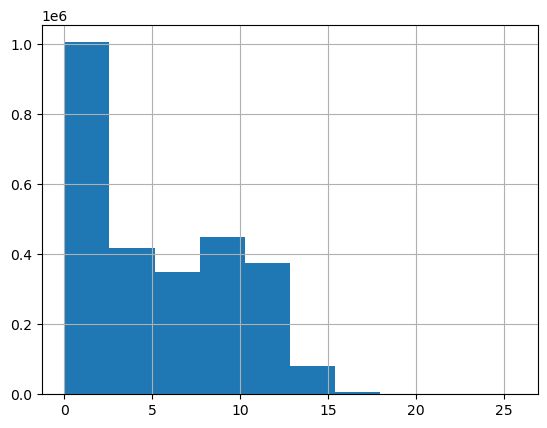

In [35]:
stdf['prd.stream_temp'].hist()

In [22]:
# Select columns with 'float64' dtype  
float64_cols = list(huc_anoms.select_dtypes(include='float64'))

# The same code again calling the columns
huc_anoms[float64_cols] = huc_anoms[float64_cols].astype('float32')

NameError: name 'huc_anoms' is not defined

## Covariate anomalies

In [13]:
cov_dir_retro = os.path.join(temp_dir, 'preds_retro/')
cov_files_retro = glob.glob(cov_dir_retro + 'seasonal_covariate_anomalies/' + '*.zip')
print(len(cov_files_retro))
print(cov_files_retro[:3])
cov_files_retro.sort()

0
[]


In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
install.packages("fst")

R[write to console]: Installing package into ‘/Users/dawn.urycki/Library/R/x86_64/4.3/library’
(as ‘lib’ is unspecified)



--- Please select a CRAN mirror for use in this session ---
Secure CRAN mirrors 

 1: 0-Cloud [https]
 2: Australia (Canberra) [https]
 3: Australia (Melbourne 1) [https]
 4: Australia (Melbourne 2) [https]
 5: Austria (Wien 1) [https]
 6: Belgium (Brussels) [https]
 7: Brazil (PR) [https]
 8: Brazil (SP 1) [https]
 9: Brazil (SP 2) [https]
10: Bulgaria [https]
11: Canada (ON 1) [https]
12: Canada (ON 2) [https]
13: Chile (Santiago) [https]
14: China (Beijing 1) [https]
15: China (Beijing 2) [https]
16: China (Beijing 3) [https]
17: China (Hefei) [https]
18: China (Hong Kong) [https]
19: China (Jinan) [https]
20: China (Lanzhou) [https]
21: China (Nanjing) [https]
22: China (Shanghai 2) [https]
23: China (Shenzhen) [https]
24: China (Wuhan) [https]
25: Colombia (Cali) [https]
26: Costa Rica [https]
27: Cyprus [https]
28: Czech Republic [https]
29: Denmark [https]
30: East Asia [https]
31: Ecuador (Cuenca) [https]
32: Finland (Helsinki) [https]
33: France (Lyon 1) [https]
34: France (Ly

Selection:  70


R[write to console]: trying URL 'https://cran.case.edu/src/contrib/fst_0.9.8.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 274495 bytes (268 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[

x86_64-apple-darwin13.4.0-clang++ -std=gnu++17 -I"/opt/miniconda3/envs/temp-data-env/lib/R/include" -DNDEBUG  -I'/Users/dawn.urycki/Library/R/x86_64/4.3/library/Rcpp/include' -I'/Users/dawn.urycki/Library/R/x86_64/4.3/library/fstcore/include' -D_FORTIFY_SOURCE=2 -isystem /opt/miniconda3/envs/temp-data-env/include -mmacosx-version-min=10.13 -mmacosx-version-min=10.13 -I/opt/miniconda3/envs/temp-data-env/include    -fPIC  -march=core2 -mtune=haswell -mssse3 -ftree-vectorize -fPIC -fstack-protector-strong -O2 -pipe -stdlib=libc++ -fvisibility-inlines-hidden -fmessage-length=0 -isystem /opt/miniconda3/envs/temp-data-env/include -fdebug-prefix-map=/Users/runner/miniforge3/conda-bld/r-base-split_1728291276454/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/opt/miniconda3/envs/temp-data-env=/usr/local/src/conda-prefix  -c RcppExports.cpp -o RcppExports.o
x86_64-apple-darwin13.4.0-clang++ -std=gnu++17 -I"/opt/miniconda3/envs/temp-data-env/lib/R/include" -DNDEBUG  -I'/Users/dawn.uryc

installing to /Users/dawn.urycki/Library/R/x86_64/4.3/library/00LOCK-fst/00new/fst/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (fst)
R[write to console]: 

R[write to console]: 
R[write to console]: The downloaded source packages are in
	‘/private/var/folders/95/99dy_ns968195cnlvp5xhwqm0000gp/T/RtmpFkiilk/downloaded_packages’
R[write to console]: 
R[write to console]: 



In [6]:
%%R
library(fst)
getwd()

R[write to console]: fst package v0.9.8



[1] "/Volumes/Elements/URycki/Repos/temp-data"


In [7]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [91]:
colsToUse = ['cov.air_temp_ws', 'cov.Flow_log', 'cov.SWE'] # future

In [279]:
colsToUse = ['cov.air_temp_ws', 'cov.NWM_flow_log', 'cov.SWE'] # retro

In [280]:
dataset = 'retro'

In [ ]:
%%time
# Future covariates
fail_list = {}

for i in range(len(hucs)):
    cur_huc = hucs[i]
    print(cur_huc)

    gcm_frames = []
    for cur_gcm in gcms:
        try: gcm_frames.append(ro.r(f"read.fst('/Volumes/Elements/URycki/temp_data/covariates_GCM/{cur_gcm}/huc_{cur_huc}.fst')"))
        except: fail_list['cur_huc'] = cur_gcm  # update this to check if fail_list['cur_huc'] exists; append cur_gcm
        
    if (cur_huc not in fail_list.keys()) & (gcm_frames != []):
        df = pd.concat(gcm_frames)
        df['date'] = pd.to_datetime(df['tim.year'] * 1000 + df['tim.doy'], format='%Y%j')
        print(df.shape)  

        huc_cov_anoms = getSeasonalAnomalies(df, baseline_period = periods['2010s'], 
                            anomaly_periods = [periods[key] for key in ('1990s', '2050s', '2080s')], cols = colsToUse)
        
        #huc_cov_anoms_reindex = huc_cov_anoms.drop(['doy', 'COMID'], level = 1, axis = 1)

        huc_cov_anoms.reset_index(names = ['COMID', 'season']).to_csv(
            os.path.join(temp_dir_gcms, 'seasonal_covariate_anomalies', f'{cur_huc}_cov_anoms.zip'), index = False, compression = 'zip')

In [ ]:
fail_list

In [31]:
indf = df
baseline_period = periods['2010s']
anomaly_periods = [periods[key] for key in ('1990s', '2050s', '2080s')]
cols = colsToUse

In [35]:
huc_cov_anoms

2010s                                                \
                cov.air_temp_ws n_cov.air_temp_ws cov.Flow_log n_cov.Flow_log   
         season                                                                 
22878641 fall          0.100403               930     0.309517            930   
         spring        7.160029               920     2.280978            920   
         summer       15.704421               920     1.171329            920   
         winter       -3.560935               882     0.313072            882   
22878643 fall          0.100403               930     0.309517            930   
...                         ...               ...          ...            ...   
22878661 winter       -3.804153               882    -0.409691            882   
22878663 fall         -0.206795               930    -0.395419            930   
         spring        6.839309               920     1.808414            920   
         summer       15.451771               920     0.425018            920   
         winter       -3.804153               882    -0.409691            882   

                                                  1990s                    \
                      cov.SWE n_cov.SWE cov.air_temp_ws n_cov.air_temp_ws   
         season                                                             
22878641 fall     1382.232207       828       -0.539059               930   
         spring   7806.388924       920       -0.565044               920   
         summer     33.150613      1022       -1.424825               920   
         winter  10728.021235       882       -0.691536               882   
22878643 fall     1382.232207       828       -0.539059               930   
...                       ...       ...             ...               ...   
22878661 winter  14254.584526       882       -0.746843               882   
22878663 fall     1445.515172       828       -0.528471               930   
         spring   7725.610998       920       -0.573852               920   
         summer      0.000000      1022       -1.492018               920   
         winter  14254.584526       882       -0.746843               882   

                                             ...        2050s                 \
                cov.Flow_log n_cov.Flow_log  ... cov.Flow_log n_cov.Flow_log   
         season                              ...                               
22878641 fall       0.170127            930  ...    -0.111811            930   
         spring     0.034979            920  ...    -0.047259            920   
         summer     0.137918            920  ...    -0.325200            920   
         winter     0.062322            882  ...     0.486865            882   
22878643 fall       0.170127            930  ...    -0.111811            930   
...                      ...            ...  ...          ...            ...   
22878661 winter     0.017833            882  ...     0.598496            882   
22878663 fall       0.153512            930  ...    -0.066162            930   
         spring     0.031868            920  ...    -0.068839            920   
         summer     0.150704            920  ...    -0.331209            920   
         winter     0.017833            882  ...     0.598496            882   

                                                 2080s                    \
                     cov.SWE n_cov.SWE cov.air_temp_ws n_cov.air_temp_ws   
         season                                                            
22878641 fall    -294.813268       828        3.679309               930   
         spring -2805.901779       920        3.656638               920   
         summer   -33.150613      1022        5.434981               920   
         winter -1428.859704       882        3.626541               883   
22878643 fall    -294.813268       828        3.679309               930   
...                      ...       ...             ...               ...   
2287866

In [37]:
huc_cov_anoms.reset_index(names = ['COMID', 'season'])

COMID  season           2010s                                 \
                      cov.air_temp_ws n_cov.air_temp_ws cov.Flow_log   
0    22878641    fall        0.100403               930     0.309517   
1    22878641  spring        7.160029               920     2.280978   
2    22878641  summer       15.704421               920     1.171329   
3    22878641  winter       -3.560935               882     0.313072   
4    22878643    fall        0.100403               930     0.309517   
..        ...     ...             ...               ...          ...   
119  22878661  winter       -3.804153               882    -0.409691   
120  22878663    fall       -0.206795               930    -0.395419   
121  22878663  spring        6.839309               920     1.808414   
122  22878663  summer       15.451771               920     0.425018   
123  22878663  winter       -3.804153               882    -0.409691   

                                                     1990s                    \
    n_cov.Flow_log       cov.SWE n_cov.SWE cov.air_temp_ws n_cov.air_temp_ws   
0              930   1382.232207       828       -0.539059               930   
1              920   7806.388924       920       -0.565044               920   
2              920     33.150613      1022       -1.424825               920   
3              882  10728.021235       882       -0.691536               882   
4              930   1382.232207       828       -0.539059               930   
..             ...           ...       ...             ...               ...   
119            882  14254.584526       882       -0.746843               882   
120            930   1445.515172       828       -0.528471               930   
121            920   7725.610998       920       -0.573852               920   
122            920      0.000000      1022       -1.492018               920   
123            882  14254.584526       882       -0.746843               882   

     ...        2050s                                                 2080s  \
     ... cov.Flow_log n_cov.Flow_log      cov.SWE n_cov.SWE cov.air_temp_ws   
0    ...    -0.111811            930  -294.813268       828        3.679309   
1    ...    -0.047259            920 -2805.901779       920        3.656638   
2    ...    -0.325200            920   -33.150613      1022        5.434981   
3    ...     0.486865            882 -1428.859704       882        3.626541   
4    ...    -0.111811            930  -294.813268       828        3.679309   
..   ...          ...            ...          ...       ...             ...   
119  ...     0.598496            882 -2421.909955       882        3.598439   
120  ...    -0.066162            930  -669.936925       828        3.674276   
121  ...    -0.068839            920 -4450.171734       920        3.594385   
122  ...    -0.331209            920     0.000000      1022        5.339664   
123  ...     0.598496            882 -2421.909955       882        3.598439   

                                                                          
    n_cov.air_temp_ws cov.Flow_log n_cov.Flow_log      cov.SWE n_cov.SWE  
0                 930    -0.104206            930  -690.998173       827  
1                 920    -0.115294            920 -5325.020264       920  
2                 920    -0.504115            920   -33.150613      1023  
3                 883     1.179680            883 -4308.032358       883  
4                 930    -0.104206            930  -690.998173       827  
..                ...          ...            ...          ...       ...  
119               883     1.384718            883 -8004.191724       883  
120               930    -0.031307            930  -865.315955       827  
121               920    -0.162504            920 -7227.741609       920  
122               920    -0.470186            920     0.000000      1023  
123               883     1.384718            883 -8004.191724       883  

[124 rows x 26 columns]

In [22]:
gcms

['CanESM2',
 'CCSM4',
 'CNRM-CM5',
 'CSIRO-Mk3-6-0',
 'GDFL-ESM2M',
 'HadGEM-CC365',
 'HadGEM2-ES',
 'inmcm4',
 'IPSL-CM5A-MR',
 'MIROC5']

In [ ]:
cov_files_retro = glob.glob(cov_dir_retro + '/*.fst')
hucs = [f[-14:-4] for f in cov_files_retro]
hucs.sort()
hucs[:5]

In [ ]:
huc_1701030801.fst

In [8]:
fst_files = glob.glob('/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro/predictions_covariates/*.fst')

In [9]:
len(fst_files)

1542

In [100]:

df = ro.r("read.fst('/Volumes/Elements/URycki/Repos/temp-data/DATA/preds_retro/predictions_covariates/huc_1701030801.fst')")


In [106]:
df.loc[df['cov.SWE'].isnull()].COMID.unique()

array([ 23026830,  23026832,  23026836,  23026838,  23026844,  23026848,
        23026852,  23026854,  23026856,  23026858,  23026860,  23026862,
        23026864,  23026870,  23026872,  23026874,  23026876,  23026878,
        23026880,  23026882,  23026884,  23026886,  23026890,  23026894,
        23026896,  23026898,  23026900,  23026906,  23026908,  23026914,
        23026916,  23026918,  23026920,  23026994,  23026998,  23027000,
        23027002,  23027004,  23027006,  23027008,  23027010,  23027012,
        23027014,  23027026,  23027028,  23027030,  23027032,  23027034,
        23027036,  23027038,  23027040,  23027042,  23027044,  23027046,
        23027048,  23027050,  23027052,  23027102,  23027104,  23027106,
        23027108,  23027110,  23027112,  23027114,  23027116,  23027118,
        23027120,  23027122,  23027124,  23027126,  23027128,  23027130,
        23027132,  23027134,  23027136,  23027138,  23027140,  23027142,
        23027146,  23027148,  23027150,  23027152, 

In [ ]:
%%time # [~8 hr for full set]
# Retro covariates

for i in range(len(hucs)):
    cur_huc = hucs[i]
    print(cur_huc)

    df = ro.r(f"read.fst('/Volumes/Elements/URycki/temp_data/covariates_retro/huc_{cur_huc}.fst')")

    df['date'] = pd.to_datetime(df['tim.year'] * 1000 + df['tim.doy'], format='%Y%j')
    print(df.shape)  

    huc_cov_anoms = getSeasonalAnomalies(df, baseline_period = periods['2010s'], 
                        anomaly_periods = [periods[key] for key in ('1990s', '2000s')], cols = colsToUse)
    
    huc_cov_anoms.reset_index(names = ['COMID', 'season']).to_csv(
        os.path.join(temp_dir_retro, 'seasonal_covariate_anomalies', f'{cur_huc}_cov_anoms.zip'), index = False, compression = 'zip')


In [21]:
fst_files[0][-14:-4]

'1705012411'

In [45]:
%%time 
# bookmark
# Retro covariates

def comidlist(fstfile):
    cur_huc = fstfile[-14:-4]
    #print(cur_huc)

    df = ro.r(f"read.fst('{fstfile}')")
    dfout = pd.DataFrame(df['COMID'].unique(), columns = ['COMID'])
    dfout['HUC10'] = cur_huc
    return dfout

CPU times: user 10 μs, sys: 2 μs, total: 12 μs
Wall time: 22.9 μs


In [ ]:
%%time 
# bookmark
# Retro covariates
res = []
i = 0
for fstfile in fst_files:
    print(i)
    cur_huc = fstfile[-14:-4]
    #print(cur_huc)

    df = ro.r(f"read.fst('{fstfile}')")
    dfout = pd.DataFrame(df['COMID'].unique(), columns = ['COMID'])
    dfout['HUC10'] = cur_huc
    res.append(dfout)
    i+=1

R[write to console]: fstcore package v0.9.18

R[write to console]: (OpenMP detected, using 16 threads)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
df_all = pd.concat(res)

In [ ]:
import multiprocess as mp

In [ ]:
%%time
with mp.Pool() as pool:
    res = pool.map(comidlist, fst_files)

In [ ]:
df_all = pd.concat(res)

In [347]:
pd.read_csv(os.path.join(temp_dir_retro, 'seasonal_covariate_anomalies', f'{cur_huc}_cov_anoms.zip'), header = [0,1], compression = 'zip')

COMID             season           2010s                    \
   Unnamed: 0_level_1 Unnamed: 1_level_1 cov.air_temp_ws n_cov.air_temp_ws   
0            22878861               fall       -0.928384               930   
1            22878861             spring        4.621116               920   
2            22878861             summer       13.584764               920   
3            22878861             winter       -4.959496               882   
4            22878865               fall        1.111995               930   
5            22878865             spring        7.250537               920   
6            22878865             summer       15.983624               920   
7            22878865             winter       -3.027337               882   
8            22879677               fall        3.946950               930   
9            22879677             spring       10.284000               920   
10           22879677             summer       19.069250               920   
11           22879677             winter       -0.943000               882   
12           22879685               fall        3.946950               930   
13           22879685             spring       10.284000               920   
14           22879685             summer       19.069250               920   
15           22879685             winter       -0.943000               882   

                                                                   1990s  \
   cov.NWM_flow_log n_cov.NWM_flow_log cov.SWE n_cov.SWE cov.air_temp_ws   
0               NaN                  0     0.0         0       -1.448457   
1               NaN                  0     0.0         0       -1.285360   
2               NaN                  0     0.0         0       -1.830384   
3               NaN                  0     0.0         0       -0.568837   
4               NaN                  0     0.0         0       -0.982254   
5               NaN                  0     0.0         0       -1.125068   
6               NaN                  0     0.0         0       -1.473579   
7               NaN                  0     0.0         0       -0.426339   
8               NaN                  0     0.0         0       -1.173950   
9               NaN                  0     0.0         0       -0.571000   
10              NaN                  0     0.0         0       -1.513249   
11              NaN                  0     0.0         0       -0.012500   
12       -11.512925                930     0.0         0       -1.173950   
13        -4.605170                920     0.0         0       -0.571000   
14       -11.512925                920     0.0         0       -1.513249   
15        -4.605170                882     0.0         0       -0.012500   

                                                                            \
   n_cov.air_temp_ws cov.NWM_flow_log n_cov.NWM_flow_log cov.SWE n_cov.SWE   
0                930              NaN                  0     0.0         0   
1                920              NaN                  0     0.0         0   
2                920              NaN                  0     0.0         0   
3                882              NaN                  0     0.0         0   
4                930              NaN                  0     0.0         0   
5                920              NaN                  0     0.0         0   
6                920              NaN                  0     0.0         0   
7                882              NaN                  0     0.0         0   
8                930              NaN                  0     0.0         0   
9                920              NaN                  0     0.0         0   
10               920              NaN                  0     0.0         0   
11               882              NaN                  0     0.0         0   
12               930         0.000000                930     0.0         0   
13               920         0.000000                920     0.0        

In [1]:
pd.read_csv(os.path.join(temp_dir_gcms, 'seasonal_covariate_anomalies', f'{cur_huc}_cov_anoms.zip'), header = [0,1], compression = 'zip')

NameError: name 'pd' is not defined